<a href="https://colab.research.google.com/github/dsinsight/GNN/blob/main/Graph_Neural_Networks_and_the_CORA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Graph Neural Network with the CORA Dataset and Model Comparision with Traditional Neural Networks**

We'll use PyTorch and PyTorch Geometric to build and train a Graph Neural Network (GNN) on the CORA dataset.
Downloading and Loading the Data

##**1. Downloading and Loading the Data**

**Installing the Required Library**
**!pip:** command installs the **torch_geometric library**, which is a library for deep learning on irregular structures like graphs, based on the PyTorch framework. It is essential for utilizing Graph Neural Networks (GNNs) and manipulating graph data structures.

**Importing Required Libraries**

- **import torch:** Imports the PyTorch library, which provides a framework for building and training neural networks.
- **from torch_geometric.datasets import Planetoid:** Imports the Planetoid class from the torch_geometric.datasets module, allowing you to load benchmark citation datasets like CORA, CiteSeer, and PubMed.

**Loading the CORA Dataset**

- **dataset = Planetoid(...):** Loads the CORA dataset, a citation network where nodes represent papers, and edges represent citation relationships.
- **oot='/tmp/Cora':** Specifies the local directory where the dataset will be downloaded and stored.
- **name='Cora':** Specifies that the CORA dataset should be loaded.

**Accessing the First Graph Object**

- **data = dataset[0]:** Retrieves the first graph object from the loaded dataset. In the context of CORA, this will be the entire citation network represented as a graph.

**Displaying Dataset Information**

- **print(f'Dataset: {dataset}'):** Displays the details of the dataset, including the number of graphs, number of nodes, etc.
- **print(f'Number of Classes: {dataset.num_classes}'):** Prints the number of unique classes (categories) of nodes in the dataset, indicating how many different types of paper categories exist in the CORA dataset.
- **print(f'Number of Node Features: {dataset.num_node_features}'):** Prints the number of features associated with each node in the dataset, indicating the dimensionality of the feature vectors for the papers.

In [21]:
!pip install torch_geometric
import torch
from torch_geometric.datasets import Planetoid

# Load the CORA dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Access the first graph object
data = dataset[0]

print(f'Dataset: {dataset}')
print(f'Number of Classes: {dataset.num_classes}')
print(f'Number of Node Features: {dataset.num_node_features}')


Dataset: Cora()
Number of Classes: 7
Number of Node Features: 1433


##**2. GNN Model Implementation**

**Importing Functions for Neural Network Layers**

- **import torch.nn.functional as F:** Imports functional operations from PyTorch, including activation functions and loss functions.
- **from torch_geometric.nn import GCNConv:** Imports the Graph Convolutional Network (GCN) convolution layer, which is used to build graph-based neural network models.

**Defining the GCN Model Class**

- **class GCN(torch.nn.Module):** Defines a new class GCN that inherits from torch.nn.Module, allowing it to be used as a neural network model.
- **super(GCN, self).__init__():** Calls the initializer of the parent class (torch.nn.Module).
- **self.conv1 = GCNConv(dataset.num_node_features, 16):** Initializes the first graph convolution layer with the number of input features equal to the number of node features and 16 output channels.
- **self.conv2 = GCNConv(16, dataset.num_classes):** Initializes the second graph convolution layer with 16 input features from the first layer and output channels equal to the number of classes.

**Defining the Forward Pass**

- **def forward(self, data):** Defines the forward pass of the GCN model, which takes input data (graph) and processes it to produce output predictions.
- **x, edge_index = data.x, data.edge_index:** Extracts the node feature matrix (x) and the edge index (edge_index) from the input graph data.
- **x = self.conv1(x, edge_index):** Applies the first graph convolution layer to aggregate features from neighboring nodes.
- **x = F.relu(x):** Applies the ReLU activation function to introduce non-linearity.
- **x = F.dropout(x, training=self.training):** Applies dropout for regularization during training to prevent overfitting.
- **x = self.conv2(x, edge_index):** Applies the second graph convolution layer to produce the logits for each class.
- **return F.log_softmax(x, dim=1):** Applies the log softmax function to the output, which converts the logits into log-probabilities for multi-class classification.

**Initializing the Model, Optimizer, and Loss Function**

- **device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'):** Checks if a GPU is available and sets the device accordingly; otherwise, it defaults to the CPU.
- **model = GCN().to(device):** Initializes the GCN model and moves it to the specified device (GPU or CPU).
- **data = data.to(device):** Transfers the data to the same device to ensure compatibility during model training.
- **optimizer = torch.optim.Adam(...):** Initializes the Adam optimizer with a learning rate of 0.01 and weight decay of 5e-4 for regularization.

In [3]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        # Two-layer GCN
        self.conv1 = GCNConv(dataset.num_node_features, 16)  # First Graph Convolution Layer
        self.conv2 = GCNConv(16, dataset.num_classes)  # Second Graph Convolution Layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First graph convolution + ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Dropout for regularization
        x = F.dropout(x, training=self.training)

        # Second graph convolution (produces logits)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


##**3. Training the GNN**

**Training Loop Definition**

- **def train():** Defines a function for the training loop.
- **model.train():** Sets the model to training mode (enables dropout and other training-specific behaviors).
- **optimizer.zero_grad():** Clears the gradients from the previous iteration.
- **out = model(data):** Passes the data through the model to get predictions.
- **loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]):** Computes the negative log-likelihood loss using only the training nodes (indicated by data.train_mask).
- **loss.backward():** Computes gradients of the loss with respect to model parameters.
- **optimizer.step():** Updates the model parameters based on the computed gradients.
- **return loss:** Returns the computed loss for logging.

**Training the GCN Model**

- **for epoch in range(200):** Runs the training loop for 200 epochs.
- **loss = train():** Calls the train() function to perform a training step.
- **print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}'):** Prints the current epoch number and the loss value after each epoch.

In [22]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(200):
    loss = train()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.0264
Epoch 2, Loss: 0.0280
Epoch 3, Loss: 0.0369
Epoch 4, Loss: 0.0212
Epoch 5, Loss: 0.0257
Epoch 6, Loss: 0.0389
Epoch 7, Loss: 0.0226
Epoch 8, Loss: 0.0258
Epoch 9, Loss: 0.0256
Epoch 10, Loss: 0.0326
Epoch 11, Loss: 0.0382
Epoch 12, Loss: 0.0352
Epoch 13, Loss: 0.0412
Epoch 14, Loss: 0.0179
Epoch 15, Loss: 0.0230
Epoch 16, Loss: 0.0251
Epoch 17, Loss: 0.0263
Epoch 18, Loss: 0.0265
Epoch 19, Loss: 0.0276
Epoch 20, Loss: 0.0337
Epoch 21, Loss: 0.0265
Epoch 22, Loss: 0.0352
Epoch 23, Loss: 0.0288
Epoch 24, Loss: 0.0308
Epoch 25, Loss: 0.0203
Epoch 26, Loss: 0.0326
Epoch 27, Loss: 0.0196
Epoch 28, Loss: 0.0303
Epoch 29, Loss: 0.0304
Epoch 30, Loss: 0.0233
Epoch 31, Loss: 0.0344
Epoch 32, Loss: 0.0286
Epoch 33, Loss: 0.0239
Epoch 34, Loss: 0.0241
Epoch 35, Loss: 0.0219
Epoch 36, Loss: 0.0270
Epoch 37, Loss: 0.0382
Epoch 38, Loss: 0.0272
Epoch 39, Loss: 0.0424
Epoch 40, Loss: 0.0287
Epoch 41, Loss: 0.0292
Epoch 42, Loss: 0.0216
Epoch 43, Loss: 0.0274
Epoch 44, Loss: 0.02

##**4. Testing the GNN model**

- **def test():** Defines a function to test the model’s performance on the test set.
- **model.eval():** Sets the model to evaluation mode (disables dropout).
- **_, pred = model(data).max(dim=1):** Passes the data through the model and retrieves the predicted class labels by selecting the maximum logit.
- **correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()):** Compares the predictions to the true labels for the test nodes and counts the number of correct predictions.
- **acc = correct / int(data.test_mask.sum()):** Calculates accuracy by dividing the number of correct predictions by the total number of test nodes.
- **return acc:** Returns the computed accuracy.

**Printing the Accuracy**

- **accuracy = test():** Calls the test() function to evaluate the model's accuracy.
- **print(f'Accuracy: {accuracy:.4f}'):** Prints the model’s accuracy on the test set.

In [5]:
# Testing the GNN model
def test():
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

accuracy = test()
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8040


##**5. Traditional Neural Network Implementation**

**Defining a Traditional Neural Network Class**

- **class TraditionalNN(torch.nn.Module):** Defines a traditional feedforward neural network class.
- **super(TraditionalNN, self).__init__():** Calls the initializer of the parent class.
- **self.fc1 = torch.nn.Linear(dataset.num_node_features, 16):** Initializes the first fully connected layer with input features equal to the number of node features and 16 output features.
- **self.fc2 = torch.nn.Linear(16, dataset.num_classes):** Initializes the second fully connected layer with 16 input features and output channels equal to the number of classes.

**Defining the Forward Pass for Traditional NN**

- **def forward(self, data):** Defines the forward pass for the traditional neural network.
- **x = data.x:** Extracts the node feature matrix.
- **x = F.relu(self.fc1(x)):** Applies the first fully connected layer followed by the ReLU activation.
- **x = F.dropout(x, training=self.training):** Applies dropout for regularization.
- **x = self.fc2(x):** Applies the second fully connected layer to produce logits.
- **return F.log_softmax(x, dim=1):** Applies log softmax to the output for classification.

**Initializing and Training the Traditional Neural Network**

- **traditional_model = TraditionalNN().to(device):** Initializes the traditional neural network and moves it to the specified device.
- **optimizer = torch.optim.Adam(...):** Initializes the Adam optimizer for the traditional model.
- **def train_traditional():** Defines a function for training the traditional neural network.
- **traditional_model.train():** Sets the model to training mode.
optimizer.zero_grad(): Clears previous gradients.
- **out = traditional_model(data):** Gets predictions from the traditional model.
- **loss = F.nll_loss(...):** Computes the negative log-likelihood loss for the training nodes.
- **loss.backward():** Computes gradients.
- **optimizer.step():** Updates the parameters.
- **for epoch in range(200):** Runs the training loop for 200 epochs and prints the loss.

**Testing the Traditional Neural Network**

- **def test_traditional():** Defines a function to test the traditional model.
- **traditional_model.eval():** Sets the model to evaluation mode.
- **_, pred = traditional_model(data).max(dim=1):** Gets predictions from the traditional model.
- **correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()):** Counts correct predictions.
- **acc = correct / int(data.test_mask.sum()):** Calculates accuracy.
- **accuracy_traditional = test_traditional():** Calls the testing function.
- **print(f'Traditional NN Accuracy: {accuracy_traditional:.4f}'):** Prints the accuracy of the traditional model.

In [6]:
class TraditionalNN(torch.nn.Module):
    def __init__(self):
        super(TraditionalNN, self).__init__()
        self.fc1 = torch.nn.Linear(dataset.num_node_features, 16)
        self.fc2 = torch.nn.Linear(16, dataset.num_classes)

    def forward(self, data):
        x = data.x
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize the traditional neural network
traditional_model = TraditionalNN().to(device)

optimizer = torch.optim.Adam(traditional_model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop for the traditional model
def train_traditional():
    traditional_model.train()
    optimizer.zero_grad()
    out = traditional_model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(200):
    loss = train_traditional()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Test traditional neural network
def test_traditional():
    traditional_model.eval()
    _, pred = traditional_model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

accuracy_traditional = test_traditional()
print(f'Traditional NN Accuracy: {accuracy_traditional:.4f}')


Epoch 1, Loss: 1.9563
Epoch 2, Loss: 1.9001
Epoch 3, Loss: 1.8499
Epoch 4, Loss: 1.7415
Epoch 5, Loss: 1.6659
Epoch 6, Loss: 1.5432
Epoch 7, Loss: 1.4263
Epoch 8, Loss: 1.3612
Epoch 9, Loss: 1.2508
Epoch 10, Loss: 1.0946
Epoch 11, Loss: 1.0450
Epoch 12, Loss: 0.9981
Epoch 13, Loss: 0.8908
Epoch 14, Loss: 0.8523
Epoch 15, Loss: 0.7013
Epoch 16, Loss: 0.7109
Epoch 17, Loss: 0.6691
Epoch 18, Loss: 0.5920
Epoch 19, Loss: 0.5338
Epoch 20, Loss: 0.5238
Epoch 21, Loss: 0.5397
Epoch 22, Loss: 0.4498
Epoch 23, Loss: 0.4248
Epoch 24, Loss: 0.4756
Epoch 25, Loss: 0.3847
Epoch 26, Loss: 0.3616
Epoch 27, Loss: 0.3651
Epoch 28, Loss: 0.3840
Epoch 29, Loss: 0.3707
Epoch 30, Loss: 0.3034
Epoch 31, Loss: 0.3277
Epoch 32, Loss: 0.2910
Epoch 33, Loss: 0.3498
Epoch 34, Loss: 0.3593
Epoch 35, Loss: 0.2987
Epoch 36, Loss: 0.3518
Epoch 37, Loss: 0.2729
Epoch 38, Loss: 0.3756
Epoch 39, Loss: 0.2780
Epoch 40, Loss: 0.2669
Epoch 41, Loss: 0.3098
Epoch 42, Loss: 0.2189
Epoch 43, Loss: 0.1762
Epoch 44, Loss: 0.26

##**6. Visualizing Graph Data**

**Graph Visualization**

- **import networkx as nx:** Imports the NetworkX library for creating and manipulating graphs.
- **import matplotlib.pyplot as plt:** Imports Matplotlib for plotting.
- **from torch_geometric.utils import to_networkx:** Imports a utility to convert PyTorch Geometric graphs to NetworkX format.
- **G = to_networkx(data, to_undirected=True):** Converts the PyTorch Geometric graph to a NetworkX graph.
- **plt.figure(figsize=(12, 12)):** Initializes a new figure for plotting with a specified size.
- **nx.draw(...):** Draws the graph using NetworkX, where:

  - **node_size=10:** Sets the size of the nodes.
  - **node_color=data.y.cpu():** Sets the color of the nodes based on their class labels.
  - **cmap=plt.get_cmap('Set3'):** Specifies the color map for the node colors.

- **plt.show():** Displays the plotted graph.

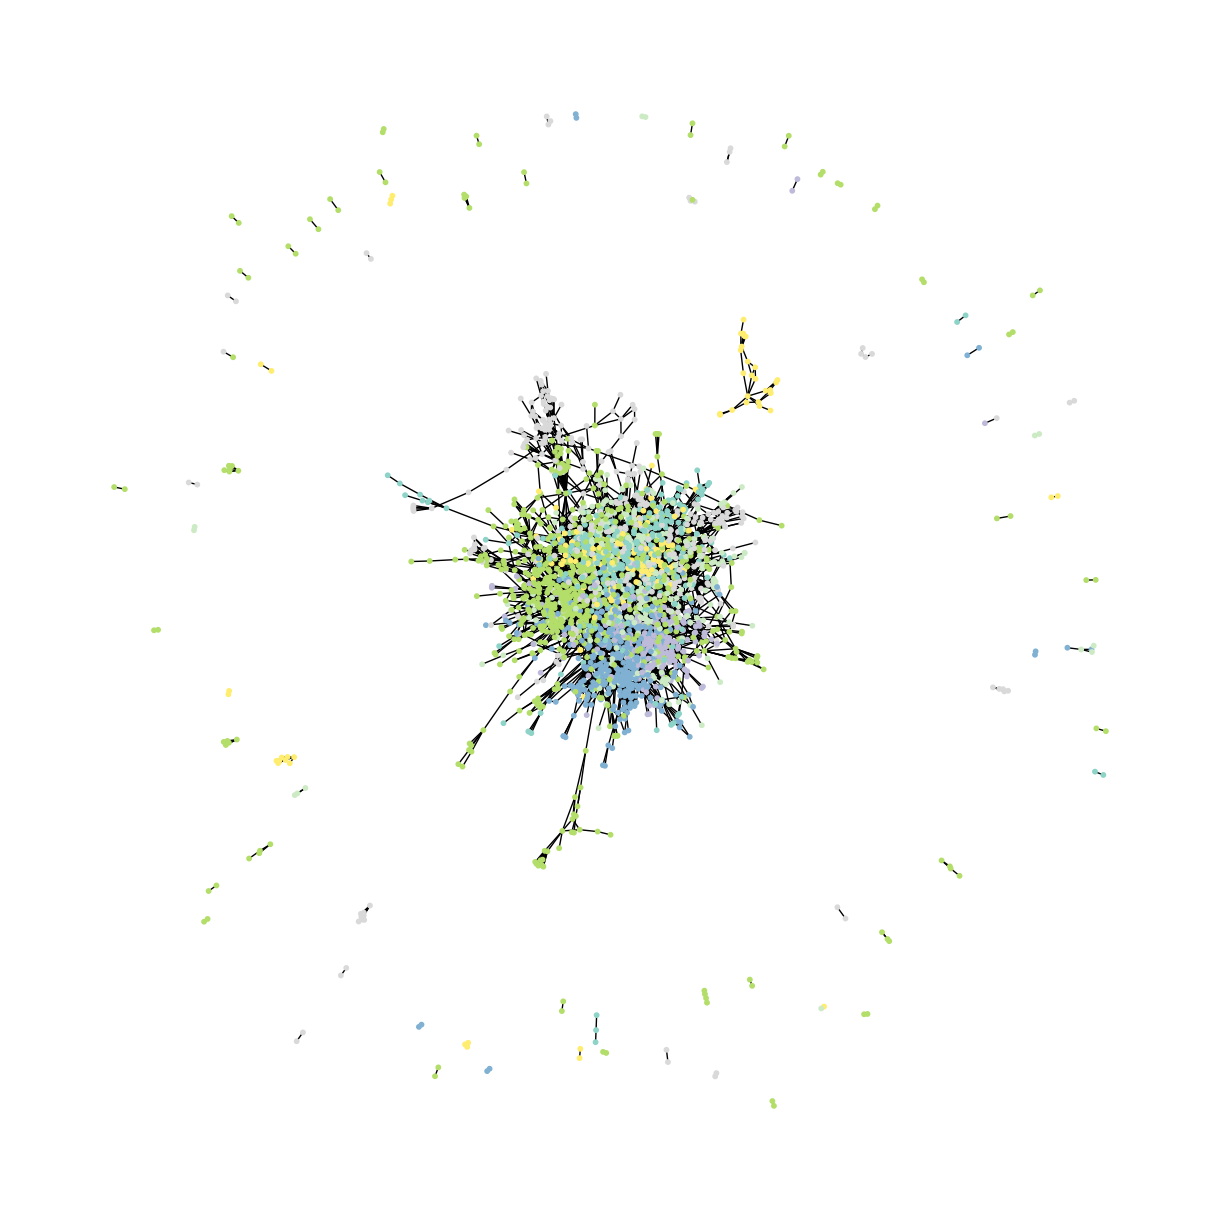

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyTorch Geometric graph to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Plot the graph
plt.figure(figsize=(12, 12))
nx.draw(G, node_size=10, node_color=data.y.cpu(), cmap=plt.get_cmap('Set3'))
plt.show()

##**3D Graph Visualization of CORA Dataset**

**Importing Libraries:** The necessary libraries for creating the graph and plotting in 3D are imported.

**Convert Graph:**
The data from the PyTorch Geometric dataset is converted to a NetworkX graph using to_networkx.

**Creating a 3D Plot:**
A 3D subplot is created using fig.add_subplot(111, projection='3d').

**Generating 3D Coordinates:**
The spring_layout function is used to generate the positions of the nodes in 3D space.

**Extracting Node Positions and Colors:**
The x, y, and z coordinates of the nodes are extracted from the layout. Node colors are derived from their class labels.

**Drawing Edges:**
For each edge in the graph, a line is drawn between the corresponding nodes in 3D space.

**Drawing Nodes:**
The nodes are plotted as a scatter plot in 3D, with colors based on their class labels.

**Adding a Color Bar:**
A color bar is added to represent the different node classes.

**Setting Labels and Title:**
The axes and title are labeled for clarity.

**Displaying the Plot:**
Finally, the plot is shown using plt.show().

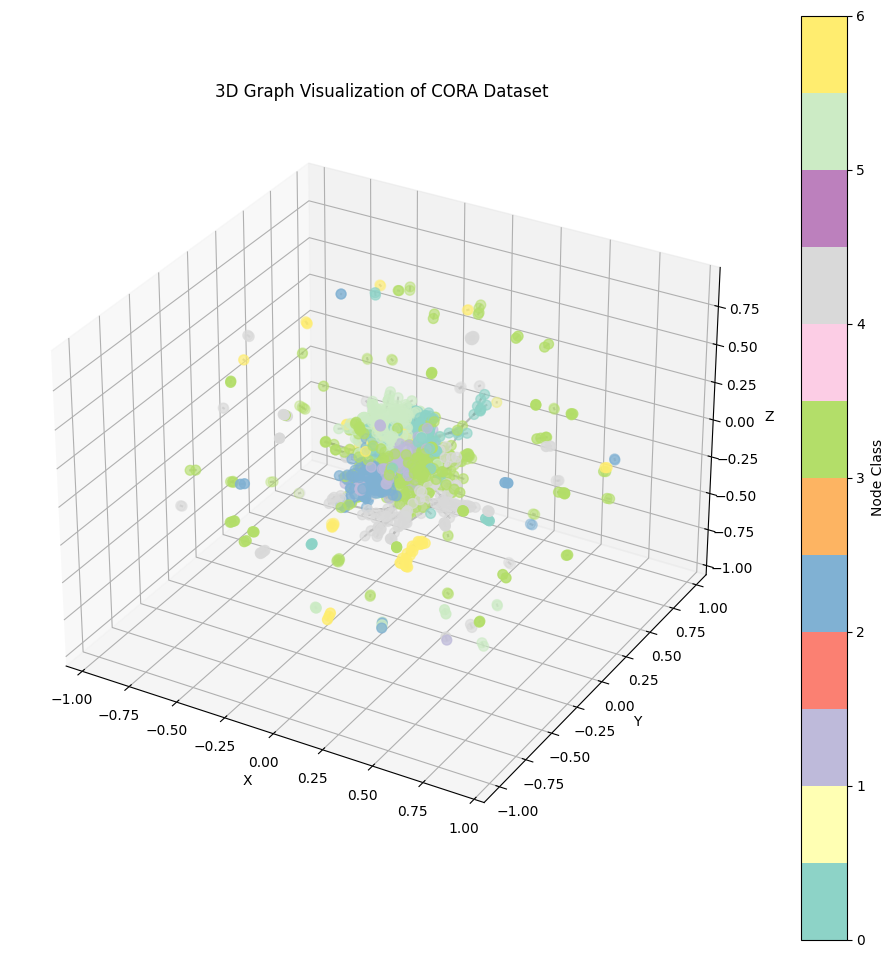

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.utils import to_networkx
import numpy as np

# Convert PyTorch Geometric graph to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Create a 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Generate 3D coordinates for the nodes
pos = nx.spring_layout(G, dim=3)  # Use the spring layout algorithm in 3D

# Extract node positions and colors
x = [pos[node][0] for node in G.nodes()]
y = [pos[node][1] for node in G.nodes()]
z = [pos[node][2] for node in G.nodes()]
colors = [data.y.cpu()[node] for node in G.nodes()]  # Node colors based on class labels

# Draw the edges
for edge in G.edges():
    x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
    y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
    z_coords = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x_coords, y_coords, z_coords, color='gray', alpha=0.5)

# Draw the nodes
scatter = ax.scatter(x, y, z, c=colors, cmap=plt.get_cmap('Set3'), s=50)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Node Class')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Graph Visualization of CORA Dataset')

# Show the plot
plt.show()
